In [1]:
import numpy as np
import pandas as pd
import sklearn.ensemble
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from math import sqrt
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import seaborn as sns
%matplotlib inline



def data_process(test=False):
    
    
    # Read file for train or test.
    
    df_raw_train = pd.read_csv('train.csv',index_col=0)
    df_raw_test = pd.read_csv('test.csv',index_col=0)

    
    # Remove outliers in training set.   
    outlier_list_scatter = [524, 1299]
    outlier_list_hard_to_fit = [463, 31, 534, 1433, 739, 1159, 108, 1231, 971, 1424 ]
    outlier_list = outlier_list_scatter + outlier_list_hard_to_fit
    df_raw_train = df_raw_train.drop(outlier_list)
    
    # Store the sale price information
    sale_price_train = df_raw_train['SalePrice']
    
    # Merge train and test df together for later process
    df_processed = pd.concat([df_raw_train, df_raw_test], sort=True)
    

    # Combine bathroom quanlitity 
    df_processed['BsmtBath'] = df_processed.BsmtFullBath + df_processed.BsmtHalfBath * 0.5
    df_processed['Bath'] = df_processed.FullBath + df_processed.HalfBath * 0.5
       
    
    ## Drop multicollinear columns 
    df_processed = df_processed.drop(['BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath'], axis=1)
    
    
    ## Missing values
    
    # 259 LotFrontage  - replace missing value with 0 
#     df_processed.LotFrontage = df_processed.LotFrontage.fillna(0)
    df_processed["LotFrontage"] = df_processed.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

    # 1369 Alley - replace with None
    df_processed.Alley = df_processed.Alley.fillna('None')

    # 8 MasVnrType and MasVnrArea - replace MasVnrType with None and MasVnrArea with 0
    df_processed.MasVnrType = df_processed.MasVnrType.fillna('None')
    df_processed.MasVnrArea = df_processed.MasVnrArea.fillna(0)

    # 37 basement: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2- replace with None
    df_processed.BsmtQual = df_processed.BsmtQual.fillna('None')
    df_processed.BsmtCond = df_processed.BsmtCond.fillna('None')
    df_processed.BsmtExposure = df_processed.BsmtExposure.fillna('None')
    df_processed.BsmtFinType1 = df_processed.BsmtFinType1.fillna('None')
    df_processed.BsmtFinType2 = df_processed.BsmtFinType2.fillna('None')
    df_processed.TotalBsmtSF = df_processed.TotalBsmtSF.fillna(0)
    

    # 690 FireplaceQu - replace with None
    df_processed.FireplaceQu = df_processed.FireplaceQu.fillna('None')

    # 81 Garage: GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond - replace with None and year with 0 
    df_processed.GarageType = df_processed.GarageType.fillna('None')
    df_processed.GarageFinish = df_processed.GarageFinish.fillna('None')
    df_processed.GarageQual = df_processed.GarageQual.fillna('None')
    df_processed.GarageCond = df_processed.GarageCond.fillna('None')
    df_processed.GarageYrBlt = df_processed.GarageYrBlt.fillna(0)

    # 1453 PoolQC - replace with None
    df_processed.PoolQC = df_processed.PoolQC.fillna('None')

    # 1179 Fence - replace with None
    df_processed.Fence = df_processed.Fence.fillna('None')

    # 1406 MiscFeature - replace with None    
    df_processed.MiscFeature = df_processed.MiscFeature.fillna('None')

    # 1 Electrical
    df_processed = df_processed[pd.notnull(df_processed.Electrical)]
    
    #Missing Value only in test data 
    
    # MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
    df_processed['MSZoning'] = df_processed['MSZoning'].fillna(df_processed['MSZoning'].mode()[0])

    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
    df_processed.drop(['Utilities'], axis=1,inplace=True)

    # Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    df_processed['Exterior1st'] = df_processed['Exterior1st'].fillna(df_processed['Exterior1st'].mode()[0])
    df_processed['Exterior2nd'] = df_processed['Exterior2nd'].fillna(df_processed['Exterior2nd'].mode()[0]) 
    
    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtBath : missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtBath'):
        df_processed[col] = df_processed[col].fillna(0)    
    
    #Garage Cars 
    df_processed.GarageCars = df_processed.GarageCars.fillna(0) 
    
    # SaleType : Fill in again with most frequent which is "WD"
    df_processed['SaleType'] = df_processed['SaleType'].fillna(df_processed['SaleType'].mode()[0])
    
    # KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
    df_processed['KitchenQual'] = df_processed['KitchenQual'].fillna(df_processed['KitchenQual'].mode()[0])    
    
    # Functional : data description says NA means typical
    df_processed["Functional"] = df_processed["Functional"].fillna("Typ")    
    

    # drop GarageArea - higher correlation than GarageACars, results are better as well
    df_processed = df_processed.drop(['GarageArea'], axis=1) 
    df_processed = df_processed.drop(['MiscFeature'], axis=1) 
#     df_processed = df_processed.drop(['1stFlrSF'], axis=1) 
    df_processed = df_processed.drop(['TotRmsAbvGrd'], axis=1) 

    
    # Feature Transformation - take the logarithm of the features.
    #Linear_Num_Cols = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'GarageArea', 'TotRmsAbvGrd', 'TotalSF', 'BsmtFinSF1']
    df_processed.GrLivArea = np.log(df_processed.GrLivArea)
    df_processed.TotalBsmtSF = np.log(df_processed.TotalBsmtSF+1)
#     df_processed.LotArea = np.log(df_processed.LotArea) -- performance decreases
#     df_processed.GarageArea = np.log(df_processed.GarageArea) -- will drop column 



    # Categorical Features Processsing

    # MSSubClass processing - MSSubClass 20-90 contains only duplicate information with HouseStyle and YearBuilt.
    df_processed['MSSubClass'] = df_processed['MSSubClass'].replace(['20','30','40','45','50','60','70','75','80','85'], '0')

    # Convert numerical to categorical. 
    df_processed['MSSubClass'] = df_processed['MSSubClass'].astype(str)

    #Encode some categorical features as ordered numbers when there is information in the order.
    df_processed = df_processed.replace({"Alley" : {"None":0,"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0,"No":1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 3, "Mod" : 2, "Gtl" : 1},
                       "LotShape" : {"IR3" : 4, "IR2" : 3, "IR1" : 2, "Reg" : 1},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2}})
    

    
    # Year processing 
    # Combine year sold with year build to year old
    df_processed['YearsOld']  = df_processed['YrSold'] - df_processed['YearBuilt']
    df_processed = df_processed.drop(['YearBuilt'], axis=1)

    # Combine YrSold and YearRemodAdd
    df_processed['YearSinceRemodel'] = df_processed['YrSold'] - df_processed['YearRemodAdd']
    df_processed = df_processed.drop(['YearRemodAdd'], axis=1)
    df_processed = df_processed.drop(['YrSold'], axis=1)
    
    # Missing rate greater than 47%, and low correlation with sale price
    df_processed = df_processed.drop(['FireplaceQu'], axis=1)

    # PoolQC has .99 missing value. drop will lower rmse
    df_processed = df_processed.drop(['PoolQC'], axis=1)
    
#     MiscVal is 0 when MiscFeature is missing. drop will lower rmse a little
#     df_processed = df_processed.drop(['MiscVal'], axis=1)
    
    #Get Dummies 
    #df_processed = pd.get_dummies(df_processed, columns=df_processed.select_dtypes(include=['object']).columns, drop_first=True)

    #get label encoder. categorical data change to numerical values
    # if label_encode:
    le = preprocessing.LabelEncoder()
    categorical_col=df_processed.select_dtypes(include=['O']).columns.to_list()
    
    for col in categorical_col: 
        le.fit(df_processed[col])
        df_processed[col] = le.fit_transform(df_processed[col])   
        
    # Split train and test data sets
    df_processed_train = df_processed[df_processed.index <= 1460].copy()
    df_processed_test = df_processed[df_processed.index > 1460].copy()
    
    # take log on price
    sale_price_train = np.log(sale_price_train)
    df_processed_train['SalePrice'] = sale_price_train    
    

    
    if test is False:
        return df_processed_train
    if test is True:
        return df_processed_test

In [3]:
train_processed=data_process()
test_processed=data_process(True)
test_processed_x = test_processed.drop(['SalePrice'], axis=1)


In [4]:
#need MLFlOW
#random search with gradient boosting regressor
    

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(train_processed)

# The predicted column is "SalePrice" .
train_x = train.drop(["SalePrice"], axis=1)
test_x = test.drop(["SalePrice"], axis=1)
train_y = train[["SalePrice"]]
test_y = test[["SalePrice"]]

def rand_search_gradient_boost(n_estimators,learn_rates,max_depths,min_samples_leaf, min_samples_split):

    param_grid = {'n_estimators': n_estimators,
                  'learning_rate': learn_rates,
                  'max_depth': max_depths,
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split}

    #random serch cross validation for gradient boosting
    random_search =RandomizedSearchCV(GradientBoostingRegressor(), 
                                      param_grid, random_state=1, 
                                      verbose=0, n_jobs=-1, cv=5)

    random_search.fit(train_x, train_y.values.ravel())
    
    print('best params:',random_search.best_params_)
    
    best_n_estimators=random_search.best_params_.get("n_estimators")
    best_learn_rates=random_search.best_params_.get("learning_rate")
    best_max_depth=random_search.best_params_.get("max_depth")
    best_min_samples_leaf=random_search.best_params_.get("min_samples_leaf")
    best_min_samples_split=random_search.best_params_.get("min_samples_split")
    

    #Mean cross-validated score of the best_estimator
    print ('cross-validated random_search test model r2:',random_search.score(test_x,test_y))
    print ('cross-validated random search train model r2:', random_search.score(train_x, train_y))
    
    y_train_pred = random_search.predict(train_x)

    test_y_pred= random_search.predict(test_x)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    #eval_metrics(actual, predicted)
    (test_rmse, test_mae, test_r2) = eval_metrics(test_y, test_y_pred)

    #eval_metrics(actual, predicted)
    (train_rmse, train_mae, train_r2) = eval_metrics(train_y, y_train_pred)

    # Print out metrics
    print("  test RMSE: %s" % test_rmse)
    print("  test mae: %s" % test_mae)
    print("  test R2: %s" % test_r2)
    print("  train RMSE: %s" % train_rmse)
    print("  train mae: %s" % train_mae)
    print("  train R2: %s" % train_r2)    
    
    
    return ()




In [5]:
#random search gradient boost

num_estimators = [int(x) for x in np.linspace(start = 100, 
                                            stop = 2000, 
                                            num = 10)]
learn_rates = [.1,.2,.3,.4,.5]
max_depths = [3,4,5,6,7,8,9,10,11,12,13,14,15]
min_samples_leaf = [3,4,5,6,7,8,9,10,11,12]
min_samples_split = [5,6,7,9,10,11]

rand_search_gradient_boost(num_estimators,learn_rates,max_depths,min_samples_leaf, min_samples_split)

best params: {'n_estimators': 733, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 3, 'learning_rate': 0.2}
cross-validated random_search test model r2: 0.9078487561770178
cross-validated random search train model r2: 0.9994657985401489
  test RMSE: 0.12268199150740638
  test mae: 0.0842713043056049
  test R2: 0.9078487561770178
  train RMSE: 0.00906232788205475
  train mae: 0.006282385091284651
  train R2: 0.9994657985401488


()

In [6]:
# #grid search for gradien boost
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV


# def grid_search_gradient_boost(n_estimators,learn_rates,max_depths,min_samples_leaf, min_samples_split):
#     param_grid = {'n_estimators': n_estimators,
#                   'learning_rate': learn_rates,
#                   'max_depth': max_depths,
#                   'min_samples_leaf': min_samples_leaf,
#                   'min_samples_split': min_samples_split}

#     grid_search = GridSearchCV(GradientBoostingRegressor(loss='huber'),
#                                param_grid, cv=3, return_train_score=True)

#     grid_search.fit(train_x, train_y.values.ravel())

    
    
     
#     print('best params:',grid_search.best_params_)
    
#     best_n_estimators=grid_search.best_params_.get("n_estimators")
#     best_learn_rates=grid_search.best_params_.get("learning_rate")
#     best_max_depth=grid_search.best_params_.get("max_depth")
#     best_min_samples_leaf=grid_search.best_params_.get("min_samples_leaf")
#     best_min_samples_split=grid_search.best_params_.get("min_samples_split")
    
#     y_pred = grid_search.predict(test_x)

#     #Mean cross-validated score of the best_estimator
#     print ('cross-validated random_search test model r2:',grid_search.score(test_x,test_y))
#     print ('cross-validated random search train model r2:', grid_search.score(train_x, train_y))


#     def eval_metrics(actual, pred):
#         rmse = np.sqrt(mean_squared_error(actual, pred))
#         mae = mean_absolute_error(actual, pred)
#         r2 = r2_score(actual, pred)
#         return rmse, mae, r2

#     #eval_metrics(actual, predicted)
#     (rmse, mae, r2) = eval_metrics(test_y, y_pred)

#     # Print out metrics
#     print("  train_test_split_RMSE: %s" % rmse)
#     print("  Train_test_split_MAE: %s" % mae)
#     print("  Train_test_split_R2: %s" % r2)

    
    
#     return (num_estimators,learn_rates,max_depths,min_samples_leaf, min_samples_split,rmse, mae,r2 )

    

In [7]:

# num_estimators_g = [100]
# learn_rates_g = [0.02, 0.05]
# max_depths_g = [1,2]
# min_samples_leaf_g = [5,10]
# min_samples_split_g = [5,10]

# grid_search_gradient_boost(num_estimators_g,learn_rates_g,max_depths_g,min_samples_leaf_g, min_samples_split_g)

In [12]:
#gradient boosting with no grid search
from sklearn.ensemble import GradientBoostingRegressor

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(train_processed)

# The predicted column is "SalePrice" .
train_x = train.drop(["SalePrice"], axis=1)
test_x = test.drop(["SalePrice"], axis=1)
train_y = train[["SalePrice"]]
test_y = test[["SalePrice"]]


def gradient_boost(n_estimators,learning_rate,max_depth,min_samples_leaf, min_samples_split):
    
    gb=GradientBoostingRegressor(loss='ls',
                               n_estimators=n_estimators,
                             learning_rate=learning_rate,
                             max_depth=max_depth,
                             min_samples_leaf=min_samples_leaf,
                             min_samples_split=min_samples_split)

    gb.fit(train_x, train_y.values.ravel())
    #predict based on train test split test_x
    y_train_pred = gb.predict(train_x)
    test_y_pred= gb.predict(test_x)

    def eval_metrics(actual, pred):
        rmse = np.sqrt(mean_squared_error(actual, pred))
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)
        return rmse, mae, r2

    #eval_metrics(actual, predicted)
    (rmse, mae, r2) = eval_metrics(test_y, test_y_pred)

    
        #eval_metrics(actual, predicted)
    (test_rmse, test_mae, test_r2) = eval_metrics(test_y, test_y_pred)

    #eval_metrics(actual, predicted)
    (train_rmse, train_mae, train_r2) = eval_metrics(train_y, y_train_pred)

    # Print out metrics
    print('n_estimator: %s' %n_estimators )
    print ('learning rate %s'%learning_rate)
    print ('max_depth %s'%max_depth)
    print ('min_samples_leaf %s'%min_samples_leaf)
    print ('min_samples_split %s'%min_samples_split)

    print("  test RMSE: %s" % test_rmse)
    print("  test mae: %s" % test_mae)
    print("  test R2: %s" % test_r2)
    print("  train RMSE: %s" % train_rmse)
    print("  train mae: %s" % train_mae)
    print("  train R2: %s" % train_r2)    
    
    sale_predict_price=gb.predict(test_processed_x)
    
    #Save Submisssion-------------------------------------------------------------------------------------------------------------------------
    file_name = './submissions'+'gradientB'+str(n_estimators)+'_'+str(learning_rate)+'_'+str(max_depth)+'_'+str(rmse)+'.csv'
    submission = pd.DataFrame({'Id':list(range(1461,2920)),'SalePrice':sale_predict_price})
    submission.to_csv(file_name,index=False)
    
    #Return Feature Importance-------------------------------------------------------------------------------------------------------------------------
    features = list(zip(list(train_x.columns.values),list(gb.feature_importances_)))
    featureImportance = pd.DataFrame(features).sort_values(by =1,ascending=False)
    featureImportance = featureImportance.rename(columns = {0:'Feature',1:'Feature Importance'})
    featureImportance = featureImportance[featureImportance['Feature Importance']!=0]

    return (n_estimators,learning_rate,max_depth,min_samples_leaf, min_samples_split,
            test_rmse,test_mae,test_r2,train_rmse,train_mae,train_r2,featureImportance )

    

In [13]:
# {'n_estimators': 733, 
#  'min_samples_split': 6,
#  'min_samples_leaf': 3, 
#  'max_depth': 3, 
#  'learning_rate': 0.2}

In [17]:
#grid search gradient boost

num_estimatorsL = []
learn_ratesL = []
max_depthsL = []
min_samples_leaf_L = []
min_samples_split_L = []
test_rmse_L=[]
test_mae_L=[]
test_r2_L=[]
train_rmse_L=[]
train_mae_L=[]
train_r2_L=[]
featureImportance_L=[]
for n_estimators in range (600,800,20):
    for learning_rate in [.01,.02]:
        for max_depth in [2,3,4]:
            for min_samples_leaf in [2,3,4]:
                for min_samples_split in [5,6,7]:
                    (n_estimators,learning_rate,
                     max_depth,min_samples_leaf, 
                     min_samples_split,
                     test_rmse,test_mae,test_r2,
                     train_rmse,train_mae,train_r2,featureImportance) =gradient_boost(n_estimators=n_estimators,
                                                                                      learning_rate=learning_rate,
                                                                                      max_depth=max_depth,
                                                                                      min_samples_leaf=min_samples_leaf, 
                                                                                      min_samples_split=min_samples_split)
                    num_estimatorsL.append(n_estimators)
                    learn_ratesL.append(learning_rate)
                    max_depthsL.append(max_depth)
                    min_samples_leaf_L.append(min_samples_leaf)
                    min_samples_split_L.append(min_samples_split)
                    test_rmse_L.append(test_rmse)
                    test_mae_L.append(test_mae)
                    test_r2_L.append(test_r2)
                    train_rmse_L.append(train_rmse)
                    train_mae_L.append(train_mae)
                    train_r2_L.append(train_r2)
                    featureImportance_L.append(featureImportance)

                    

n_estimator: 600
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.141935254408308
  test mae: 0.09731912607540291
  test R2: 0.8841354758565761
  train RMSE: 0.10407081041017308
  train mae: 0.07622031062452146
  train R2: 0.9272258436594555
n_estimator: 600
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.14195392207668633
  test mae: 0.09733364595987193
  test R2: 0.8841049962867356
  train RMSE: 0.10407081041017312
  train mae: 0.07622031062452152
  train R2: 0.9272258436594554
n_estimator: 600
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.1419444309601226
  test mae: 0.09732631571404216
  test R2: 0.8841204933748175
  train RMSE: 0.10407081041017312
  train mae: 0.07622031062452152
  train R2: 0.9272258436594554
n_estimator: 600
learning rate 0.01
max_depth 2
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.14188303806040234
  test mae: 0.0974426039067399
  test R2: 0

n_estimator: 600
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12948582554263266
  test mae: 0.0879001290439838
  test R2: 0.9035695083017321
  train RMSE: 0.08563268059602014
  train mae: 0.06413514137012742
  train R2: 0.9507282049314394
n_estimator: 600
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.12948582554263266
  test mae: 0.0879001290439838
  test R2: 0.9035695083017321
  train RMSE: 0.08563268059602014
  train mae: 0.06413514137012742
  train R2: 0.9507282049314394
n_estimator: 600
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.12948582554263266
  test mae: 0.0879001290439838
  test R2: 0.9035695083017321
  train RMSE: 0.08563268059602014
  train mae: 0.06413514137012742
  train R2: 0.9507282049314394
n_estimator: 600
learning rate 0.02
max_depth 2
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12942503505995198
  test mae: 0.08763788359120801
  test R2: 

n_estimator: 620
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.1409980173583509
  test mae: 0.0967977482048362
  test R2: 0.8856605936616013
  train RMSE: 0.1030879496730336
  train mae: 0.07544054200969892
  train R2: 0.9285939334307955
n_estimator: 620
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.14099801735835088
  test mae: 0.09679774820483616
  test R2: 0.8856605936616013
  train RMSE: 0.10308794967303363
  train mae: 0.07544054200969891
  train R2: 0.9285939334307955
n_estimator: 620
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.14099801735835094
  test mae: 0.09679774820483615
  test R2: 0.8856605936616012
  train RMSE: 0.10308794967303352
  train mae: 0.07544054200969884
  train R2: 0.9285939334307957
n_estimator: 620
learning rate 0.01
max_depth 3
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.1298674815537053
  test mae: 0.08933130862345999
  test R2: 0

n_estimator: 620
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12425178540636833
  test mae: 0.08479046360736413
  test R2: 0.9112077222048821
  train RMSE: 0.0637185002953376
  train mae: 0.04925407444118471
  train R2: 0.9727196211291129
n_estimator: 620
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.124279540343897
  test mae: 0.08504111806531775
  test R2: 0.9111680495456527
  train RMSE: 0.06404063022860969
  train mae: 0.04948686576311311
  train R2: 0.9724430910762716
n_estimator: 620
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.12425205826725814
  test mae: 0.08502474962413865
  test R2: 0.9112073322230971
  train RMSE: 0.06400502040922414
  train mae: 0.04942974265564232
  train R2: 0.9724737286174986
n_estimator: 620
learning rate 0.02
max_depth 3
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12371591540788027
  test mae: 0.08487873336758199
  test R2: 

n_estimator: 640
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12946974333332772
  test mae: 0.08924972346246217
  test R2: 0.9035934602522768
  train RMSE: 0.07878572252899234
  train mae: 0.0601966650456589
  train R2: 0.9582924815204672
n_estimator: 640
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.1294788526961705
  test mae: 0.08925019415835228
  test R2: 0.9035798936378219
  train RMSE: 0.07878572252899234
  train mae: 0.0601966650456589
  train R2: 0.9582924815204672
n_estimator: 640
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.12944474701055084
  test mae: 0.08923494277307759
  test R2: 0.9036306824834501
  train RMSE: 0.07876787580077112
  train mae: 0.060167006596171045
  train R2: 0.9583113747518309
n_estimator: 640
learning rate 0.01
max_depth 3
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12878258899233508
  test mae: 0.0888832465406874
  test R2: 

n_estimator: 640
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12266710164741648
  test mae: 0.08410785523129279
  test R2: 0.9134581590983114
  train RMSE: 0.06469271881309153
  train mae: 0.049502299227547994
  train R2: 0.9718790418969339
n_estimator: 640
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.1226637991442215
  test mae: 0.08410483287615071
  test R2: 0.9134628188783984
  train RMSE: 0.06469271881309166
  train mae: 0.04950229922754807
  train R2: 0.9718790418969337
n_estimator: 640
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.12265939824589114
  test mae: 0.08409971143480409
  test R2: 0.913469028281771
  train RMSE: 0.06469271881309153
  train mae: 0.049502299227547994
  train R2: 0.9718790418969339
n_estimator: 640
learning rate 0.02
max_depth 4
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.1260601970531019
  test mae: 0.08582840123527655
  test R2

n_estimator: 660
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12910956881165983
  test mae: 0.08744302144500511
  test R2: 0.904129104795718
  train RMSE: 0.05801831634793956
  train mae: 0.04492003931181984
  train R2: 0.9773822421599507
n_estimator: 660
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.1287626496974265
  test mae: 0.08749692646944447
  test R2: 0.904643625323757
  train RMSE: 0.05804005445247464
  train mae: 0.04506207801644137
  train R2: 0.9773652902963559
n_estimator: 660
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.12850074990146396
  test mae: 0.0875546484818505
  test R2: 0.9050311354766329
  train RMSE: 0.05823575685128301
  train mae: 0.04512628873204755
  train R2: 0.9772123912298378
n_estimator: 660
learning rate 0.01
max_depth 4
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.1284184239464706
  test mae: 0.08732968563476867
  test R2: 0.

n_estimator: 660
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12543576875145804
  test mae: 0.08523917804853862
  test R2: 0.9095074736683332
  train RMSE: 0.04503284676949612
  train mae: 0.03404286521534315
  train R2: 0.9863736948509978
n_estimator: 660
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.12534805284728687
  test mae: 0.08517052503549297
  test R2: 0.9096339903468739
  train RMSE: 0.04503284676949612
  train mae: 0.03404286521534315
  train R2: 0.9863736948509978
n_estimator: 660
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.12540485825166112
  test mae: 0.0854774470791699
  test R2: 0.9095520674010226
  train RMSE: 0.04541181154630461
  train mae: 0.03434302542948339
  train R2: 0.9861433910663597
n_estimator: 660
learning rate 0.02
max_depth 4
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12399025518298709
  test mae: 0.08521820215811132
  test R2

n_estimator: 680
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12678656121180273
  test mae: 0.08720962524335589
  test R2: 0.9075479880406101
  train RMSE: 0.05886279961773816
  train mae: 0.045093921298326116
  train R2: 0.9767190266010308
n_estimator: 680
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.12686859123267263
  test mae: 0.08728943995964468
  test R2: 0.9074283177262813
  train RMSE: 0.05886279961773816
  train mae: 0.045093921298326116
  train R2: 0.9767190266010308
n_estimator: 680
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.12680088104313236
  test mae: 0.08722619972894306
  test R2: 0.9075271029883132
  train RMSE: 0.05886279961773816
  train mae: 0.045093921298326116
  train R2: 0.9767190266010308
n_estimator: 680
learning rate 0.02
max_depth 2
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12848803234780465
  test mae: 0.08703193109954839
  tes

n_estimator: 700
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.13815200138492212
  test mae: 0.09450163272906566
  test R2: 0.8902298436125123
  train RMSE: 0.09848084556723073
  train mae: 0.07261739684744714
  train R2: 0.9348337328967407
n_estimator: 700
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.1381425468863729
  test mae: 0.09449404408696126
  test R2: 0.8902448674451313
  train RMSE: 0.09848084556723073
  train mae: 0.07261739684744714
  train R2: 0.9348337328967407
n_estimator: 700
learning rate 0.01
max_depth 2
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.1381425468863729
  test mae: 0.09449404408696126
  test R2: 0.8902448674451313
  train RMSE: 0.09848084556723073
  train mae: 0.07261739684744714
  train R2: 0.9348337328967407
n_estimator: 700
learning rate 0.01
max_depth 2
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.13817935040874021
  test mae: 0.09469090878868608
  test R2:

n_estimator: 700
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12814075705122896
  test mae: 0.08689700830088366
  test R2: 0.9055624977218723
  train RMSE: 0.08278404424975849
  train mae: 0.062079181873285455
  train R2: 0.9539518078122471
n_estimator: 700
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.12814020803614024
  test mae: 0.086894287151297
  test R2: 0.9055633069492222
  train RMSE: 0.08278404424975849
  train mae: 0.062079181873285455
  train R2: 0.9539518078122471
n_estimator: 700
learning rate 0.02
max_depth 2
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.1281836124740815
  test mae: 0.0869384896452607
  test R2: 0.9054993197611234
  train RMSE: 0.08277981391722164
  train mae: 0.0620801819657776
  train R2: 0.9539565138927543
n_estimator: 700
learning rate 0.02
max_depth 2
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.1281903267879533
  test mae: 0.08668342217098209
  test R2: 0

n_estimator: 720
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.1374391637198016
  test mae: 0.09401615528431666
  test R2: 0.8913597067795785
  train RMSE: 0.09813653214319537
  train mae: 0.0723282459183425
  train R2: 0.9352886111360559
n_estimator: 720
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.13743916371980158
  test mae: 0.09401615528431663
  test R2: 0.8913597067795787
  train RMSE: 0.09813653214319537
  train mae: 0.0723282459183425
  train R2: 0.9352886111360559
n_estimator: 720
learning rate 0.01
max_depth 2
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.13743916371980175
  test mae: 0.09401615528431663
  test R2: 0.8913597067795783
  train RMSE: 0.09813653214319544
  train mae: 0.07232824591834244
  train R2: 0.9352886111360559
n_estimator: 720
learning rate 0.01
max_depth 3
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.127829274770543
  test mae: 0.0878187872580042
  test R2: 0.9

n_estimator: 720
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12344381766456136
  test mae: 0.08428226682360664
  test R2: 0.9123587405365166
  train RMSE: 0.06062566749381382
  train mae: 0.04691429471139283
  train R2: 0.9753036726549144
n_estimator: 720
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.12374555353381138
  test mae: 0.08470197063138121
  test R2: 0.9119297707995627
  train RMSE: 0.060826014614604865
  train mae: 0.04701101258765374
  train R2: 0.9751401771013019
n_estimator: 720
learning rate 0.02
max_depth 3
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.12350489899920943
  test mae: 0.08456346698405298
  test R2: 0.9122719873945395
  train RMSE: 0.0609083562857266
  train mae: 0.04708738343785008
  train R2: 0.9750728248372772
n_estimator: 720
learning rate 0.02
max_depth 3
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12305880113802961
  test mae: 0.08432536553070646
  test R

n_estimator: 740
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12770492264467317
  test mae: 0.08789152212153159
  test R2: 0.9062038099505331
  train RMSE: 0.07509863840676424
  train mae: 0.05756151794018291
  train R2: 0.962104867275192
n_estimator: 740
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.12772066822670441
  test mae: 0.08789708843225186
  test R2: 0.906180679023065
  train RMSE: 0.07509863840676424
  train mae: 0.05756151794018291
  train R2: 0.962104867275192
n_estimator: 740
learning rate 0.01
max_depth 3
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.12756751091167762
  test mae: 0.08779141458260309
  test R2: 0.90640555257055
  train RMSE: 0.07505061988566548
  train mae: 0.057545630438388944
  train R2: 0.9621533125337339
n_estimator: 740
learning rate 0.01
max_depth 3
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.1268275391331887
  test mae: 0.08754554197090428
  test R2: 0.

n_estimator: 740
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12227579381290639
  test mae: 0.08369143215190018
  test R2: 0.9140094150757649
  train RMSE: 0.06166244369074819
  train mae: 0.047129940003787944
  train R2: 0.9744517727664518
n_estimator: 740
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.12228194087807684
  test mae: 0.08369507985091001
  test R2: 0.9140007689979149
  train RMSE: 0.06166244369074822
  train mae: 0.04712994000378797
  train R2: 0.9744517727664518
n_estimator: 740
learning rate 0.02
max_depth 3
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.12226517856104012
  test mae: 0.08369804244299574
  test R2: 0.9140243448025116
  train RMSE: 0.06166244369074822
  train mae: 0.04712994000378797
  train R2: 0.9744517727664518
n_estimator: 740
learning rate 0.02
max_depth 4
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12568799828343413
  test mae: 0.08544576918374133
  test 

n_estimator: 760
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.12779897210165977
  test mae: 0.0866856707360513
  test R2: 0.9060656049559431
  train RMSE: 0.054747794019733974
  train mae: 0.04237307029030073
  train R2: 0.9798603204648724
n_estimator: 760
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 6
  test RMSE: 0.12758845616507594
  test mae: 0.08683848459751814
  test R2: 0.9063748155852572
  train RMSE: 0.054797606939453535
  train mae: 0.04249850072541283
  train R2: 0.9798236551470513
n_estimator: 760
learning rate 0.01
max_depth 4
min_samples_leaf 2
min_samples_split 7
  test RMSE: 0.12764344635955288
  test mae: 0.08696335680386529
  test R2: 0.9062940939159203
  train RMSE: 0.0551149068011033
  train mae: 0.04257334096226047
  train R2: 0.9795893205946122
n_estimator: 760
learning rate 0.01
max_depth 4
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.12788844713710837
  test mae: 0.08701506209090003
  test R

n_estimator: 760
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 5
  test RMSE: 0.1253557451728816
  test mae: 0.08505623438691197
  test R2: 0.9096228988926028
  train RMSE: 0.04205032549439316
  train mae: 0.031702419745364065
  train R2: 0.9881188622759302
n_estimator: 760
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 6
  test RMSE: 0.12535499161335262
  test mae: 0.08511004775713968
  test R2: 0.9096239854693839
  train RMSE: 0.04205032549439316
  train mae: 0.031702419745364065
  train R2: 0.9881188622759302
n_estimator: 760
learning rate 0.02
max_depth 4
min_samples_leaf 3
min_samples_split 7
  test RMSE: 0.12520553383072927
  test mae: 0.08516957292176774
  test R2: 0.9098393633539789
  train RMSE: 0.04210656102574551
  train mae: 0.031793109938634774
  train R2: 0.9880870628141524
n_estimator: 760
learning rate 0.02
max_depth 4
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12405298073651948
  test mae: 0.08520275968834852
  test

n_estimator: 780
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 5
  test RMSE: 0.12610357219871618
  test mae: 0.08672043201988425
  test R2: 0.9085413682973744
  train RMSE: 0.0560816389606498
  train mae: 0.04278637156760571
  train R2: 0.978867022001263
n_estimator: 780
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 6
  test RMSE: 0.126055504718226
  test mae: 0.08671804928681956
  test R2: 0.9086110784262968
  train RMSE: 0.0560816389606498
  train mae: 0.04278637156760571
  train R2: 0.978867022001263
n_estimator: 780
learning rate 0.01
max_depth 4
min_samples_leaf 4
min_samples_split 7
  test RMSE: 0.12605158966057103
  test mae: 0.08669409062870174
  test R2: 0.9086167550897886
  train RMSE: 0.056081638960649736
  train mae: 0.04278637156760566
  train R2: 0.978867022001263
n_estimator: 780
learning rate 0.02
max_depth 2
min_samples_leaf 2
min_samples_split 5
  test RMSE: 0.1270152910210126
  test mae: 0.08576439599730964
  test R2: 0.90

In [86]:

result=pd.DataFrame(list(zip(num_estimatorsL,learn_ratesL,max_depthsL,min_samples_leaf_L,min_samples_split_L,
                     test_rmse_L,test_mae_L,test_r2_L,train_rmse_L,train_mae_L,train_r2_L,featureImportance_L)),columns=["num_estimatorsL","learn_ratesL","max_depthsL","min_samples_leaf_L","min_samples_split_L",
                     "test_rmse_L","test_mae_L","test_r2_L","train_rmse_L","train_mae_L","train_r2_L","featureImportance_L"])
result.to_csv('result_gradient_boost',index=False)
result.head()

,num_estimatorsL,learn_ratesL,max_depthsL,min_samples_leaf_L,min_samples_split_L,test_rmse_L,test_mae_L,test_r2_L,train_rmse_L,train_mae_L,train_r2_L,featureImportance_L
0,600,0.01,2,2,5,0.141935,0.097319,0.884135,0.104071,0.07622,0.927226,Feature Feature Importance 55 ...
1,600,0.01,2,2,6,0.141954,0.097334,0.884105,0.104071,0.07622,0.927226,Feature Feature Importance 55 ...
2,600,0.01,2,2,7,0.141944,0.097326,0.884120,0.104071,0.07622,0.927226,Feature Feature Importance 55 ...
3,600,0.01,2,3,5,0.141883,0.097443,0.884221,0.104131,0.07615,0.927142,Feature Feature Importance 55 ...
4,600,0.01,2,3,6,0.141883,0.097443,0.884221,0.104131,0.07615,0.927142,Feature Feature Importance 55 ...


In [93]:
#find the best test_rmse
result.sort_values(by='test_rmse_L', ascending=True)

result.iloc[529]['featureImportance_L']

,Feature,Feature Importance
55,OverallQual,0.408415
33,GrLivArea,0.165029
64,TotalBsmtSF,0.064588
20,ExterQual,0.037829
27,GarageCars,0.037571
38,KitchenQual,0.029749
69,YearSinceRemodel,0.026727
68,YearsOld,0.024356
41,LotArea,0.020273
24,Fireplaces,0.018364


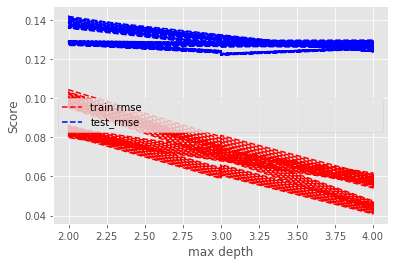

In [79]:
#graph max depth vs Score
train_vs_test=result.loc[:,['max_depthsL',"test_rmse_L",'train_rmse_L']]
plt.plot('max_depthsL', 'train_rmse_L', 'r--', data=train_vs_test, label = 'train rmse')
plt.plot('max_depthsL', 'test_rmse_L', 'b--', data=train_vs_test, label = 'test_rmse')
plt.legend(loc='best', mode="expand")
plt.xlabel('max depth')
plt.ylabel('Score')

plt.show()

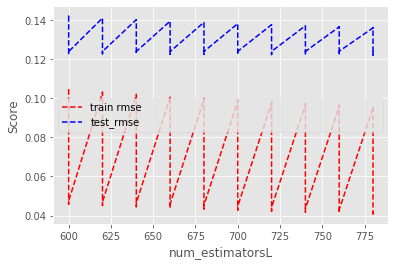

In [81]:
#graph max depth vs Score
train_vs_test=result.loc[:,['num_estimatorsL',"test_rmse_L",'train_rmse_L']]
plt.plot('num_estimatorsL', 'train_rmse_L', 'r--', data=train_vs_test, label = 'train rmse')
plt.plot('num_estimatorsL', 'test_rmse_L', 'b--', data=train_vs_test, label = 'test_rmse')
plt.legend(loc='best', mode="expand")
plt.xlabel('num_estimatorsL')
plt.ylabel('Score')

plt.show()

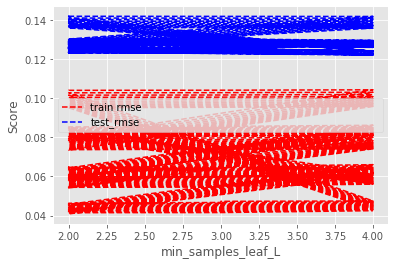

In [83]:
#graph max depth vs Score
train_vs_test=result.loc[:,['min_samples_leaf_L',"test_rmse_L",'train_rmse_L']]
plt.plot('min_samples_leaf_L', 'train_rmse_L', 'r--', data=train_vs_test, label = 'train rmse')
plt.plot('min_samples_leaf_L', 'test_rmse_L', 'b--', data=train_vs_test, label = 'test_rmse')
plt.legend(loc='best', mode="expand")
plt.xlabel('min_samples_leaf_L')
plt.ylabel('Score')

plt.show()